Account for AOI reflection losses
===========================

In this section, we will learn how:

- to run full timeseries simulations that account for diffuse AOI losses with the ``PVEngine``
- to run full timeseries simulations that account for non-diffuse AOI losses with the ``PVEngine``
- to run full timeseries simulations that account for non-diffuse AOI losses with the ``PVEngine``

Imports and settings

In [1]:
# Import external libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
# Paths
LOCAL_DIR = os.getcwd()
DATA_DIR = os.path.join(LOCAL_DIR, 'data')
filepath = os.path.join(DATA_DIR, 'test_df_inputs_MET_clearsky_tucson.csv')

RUN_FIXED_TILT = True

### Get timeseries inputs

In [2]:
def export_data(fp):
    tz = 'US/Arizona'
    df = pd.read_csv(fp, index_col=0)
    df.index = pd.DatetimeIndex(df.index).tz_convert(tz)
    return df

df = export_data(filepath)
df_inputs = df.iloc[:48, :]

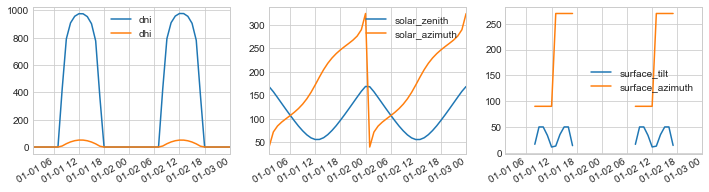

In [3]:
# Plot the data
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
df_inputs[['dni', 'dhi']].plot(ax=ax1)
df_inputs[['solar_zenith', 'solar_azimuth']].plot(ax=ax2)
df_inputs[['surface_tilt', 'surface_azimuth']].plot(ax=ax3)
plt.show()

In [4]:
# Use a fixed albedo
albedo = 0.2

### Prepare PV array parameters

In [5]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
}

### Default behavior

By default, ``pvfactors`` assumes that all reflection losses (AOI losses) are diffuse; i.e. they do not depend on angle of incidence (AOI). Here is an example.  

Let's run a full mode simulation (reflection equilibrium) and compare the calculated incident and absorbed irradiance on both sides of a PV row in a modeled PV array.

In [6]:
from pvfactors.geometry import OrderedPVArray
# Create PV array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)

In [7]:
from pvfactors.engine import PVEngine
# Create engine
engine = PVEngine(pvarray)
# Fit engine to data
engine.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
           df_inputs.solar_zenith, df_inputs.solar_azimuth, 
           df_inputs.surface_tilt, df_inputs.surface_azimuth, 
           albedo)

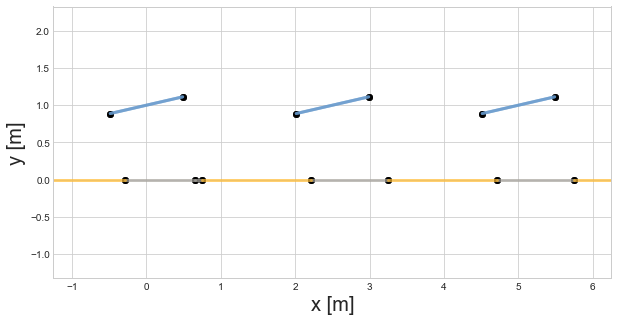

In [8]:
# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(10, 5))
pvarray.plot_at_idx(12, ax)
plt.show()

In [9]:
# Create a function that will build a report
def fn_report(pvarray): return {'qinc_back': pvarray.ts_pvrows[1].back.get_param_weighted('qinc'),
                                'qabs_back': pvarray.ts_pvrows[1].back.get_param_weighted('qabs')}

# Run full mode simulation
report = engine.run_full_mode(fn_build_report=fn_report)

# Print results (report is defined by report function passed by user)
df_report = pd.DataFrame(report, index=df_inputs.index)

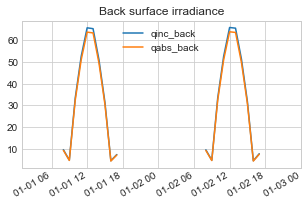

In [10]:
# Plot irradiance
f, ax = plt.subplots(figsize=(5, 3))
df_report.plot(ax=ax)
ax.set_title('Back surface irradiance')
plt.show()

Let's plot the back AOI losses

Text(0.5, 1.0, 'Back AOI losses')

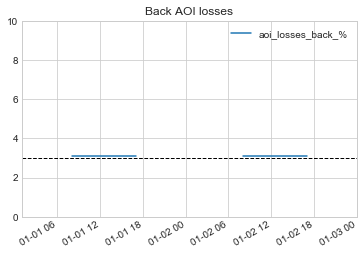

In [11]:
df_report['aoi_losses_back_%'] = (df_report['qinc_back'] - df_report['qabs_back']) / df_report['qabs_back'] * 100.

# plotting
f, ax = plt.subplots()
df_report[['aoi_losses_back_%']].plot(ax=ax)
ax.axhline(engine.irradiance.rho_back * 100., color='k', linestyle='--', linewidth=1)
ax.set_ylim(0, 10)
ax.set_title('Back AOI losses')

In [12]:
df_report.describe()

,qinc_back,qabs_back,aoi_losses_back_%
count,20.000000,20.000000,2.000000e+01
mean,32.667905,31.687868,3.092784e+00
std,24.307125,23.577911,2.599045e-14
min,4.625409,4.486646,3.092784e+00
25%,7.748197,7.515751,3.092784e+00
50%,32.624591,31.645853,3.092784e+00
75%,52.537529,50.961403,3.092784e+00
max,65.816244,63.841757,3.092784e+00


In [13]:
engine.irradiance.faoi_back

{'direct': array([0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]),
 'circumsolar': array([0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]),
 'horizon': array([0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97])}

In [14]:
engine.pvarray.ts_vf_aoi_matrix[:, :, 12].sum(axis=1)

array([0.  , 0.  , 0.8 , 0.8 , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.8 , 0.8 , 0.8 , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.8 , 0.99, 0.  , 0.97, 0.  , 0.99, 0.  , 0.97, 0.  , 0.99, 0.  , 0.97, 0.  , 0.  ])